In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import pandas as pd
import os
import pygmm
from scipy.interpolate import interp1d
import scipy.stats
import sys
from sqlite3 import connect
sys.path.append("/resnick/groups/enceladus/jyzhao/Scalable_GPs_jz/regression_gpytorch/src")
from training_utils.utils import read_hdf5

In [2]:
# Parallel calculation utilities
from joblib import Parallel, delayed
import multiprocessing
import time
import contextlib
import joblib
from tqdm import tqdm
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
# Define some data dir
fn_metadata = "/resnick/groups/enceladus/jyzhao/Scalable_GPs_jz/preprocessing/gm_metadata_expanded.csv"
sites_file = "/resnick/groups/enceladus/glavrent/Scalable_GPs/Raw_files/scec/study_22.12_sites.csv"
rup_var_per_eq_file = "/resnick/groups/enceladus/jyzhao/Scalable_GPs_jz/preprocessing/rup_var_per_eq.json"
formatted_data_dir = "/resnick/groups/enceladus/jyzhao/Scalable_GPs_jz/regression_gpytorch/output/formatted_data"
prediction_outputs_svgp_cuda_dir = "/resnick/groups/enceladus/jyzhao/Scalable_GPs_jz/regression_gpytorch/output/prediction_outputs_svgp_cuda"
dir_gm_db = '/resnick/groups/enceladus/glavrent/Scalable_GPs/Data/preprocessing/'
fn_gm_db = dir_gm_db + 'gm_db.sqlite'

In [4]:
# Load metadata
metadata = pd.read_csv(fn_metadata)

In [5]:
# Define sites to plot
sites_to_plot = ['s433', 'PLS', 's153', 's399'] # Training sites
# sites_to_plot = ['s634', 'PACI'] # Test sites

In [6]:
# Plot all stations
sites_gdf = pd.read_csv(sites_file)
sites_gdf = gpd.GeoDataFrame(sites_gdf, 
    geometry=gpd.points_from_xy(sites_gdf.site_lon, sites_gdf.site_lat), 
    crs="EPSG:4326")
map = sites_gdf.explore()

sites_gdf_subset = sites_gdf[sites_gdf['site_id'].isin(sites_to_plot)]
sites_gdf_subset.explore(m = map, color = 'red')

In [7]:
num_training_eqs = 400
num_training_epochs = 2500
ngmm_results_dir = os.path.join(prediction_outputs_svgp_cuda_dir,
    f'{num_training_eqs}_training_eqs_{num_training_epochs}_epochs')
ngmm_results_file = os.path.join(ngmm_results_dir, 'svgp_pred.csv')
ngmm_results = pd.read_csv(ngmm_results_file)
ngmm_likelihood_file = os.path.join(ngmm_results_dir, 'likelihood.csv')
ngmm_likelihood = pd.read_csv(ngmm_likelihood_file)
likelihood_noise = ngmm_likelihood['noise_covar'].values[0]
ngmm_results['pred_mean'].mean()

np.float64(0.17838606554069633)

In [8]:
site_id = sites_to_plot[3]
ngmm_results_site = ngmm_results[ngmm_results['site_id'] == site_id].copy()
print(ngmm_results_site['pred_mean'].mean())

-0.064460505629708


In [79]:
gmm = pygmm.AbrahamsonSilvaKamai2014
metadata_subset = metadata[metadata['site_id'] == site_id]
period = 2.0
for i, row in tqdm(ngmm_results_site.iterrows(), total=ngmm_results_site.shape[0]):
# for i, row in ngmm_results_site.iterrows():
    eq_var_id = row['eq_var_id']
    eq_id = int(eq_var_id // 1000)
    rup_var_id = int(eq_var_id % 1000)
    site_id = row['site_id']
    gm = metadata_subset[(metadata_subset['eq_id'] == eq_id) & (metadata_subset['site_id'] == site_id)].iloc[0]
    s = pygmm.model.Scenario(mag=gm['mag'], dip=gm['dip'], mechanism='SS',
                                depth_tor=gm['z_tor'],  width=gm['width'],
                                dist_rup=gm['Rrup'], dist_jb=gm['Rjb'],
                                dist_x=gm['Rx'], dist_y0=gm['Ry0'],
                                v_s30=gm['vs30_scec'], depth_1_0=gm['z1.0'])
    gmm_obj = gmm(s)
    ngmm_results_site.loc[i, 'gmm_mean'] = gmm_obj.interp_spec_accels(period)
    ngmm_results_site.loc[i, 'gmm_ln_std'] = gmm_obj.interp_ln_stds(period)
    ngmm_results_site.loc[i, 'gmm_ln_tau'] = interp1d(
        np.log(gmm_obj.periods), gmm_obj._tau[gmm_obj.INDICES_PSA], kind='linear',
        copy = False, bounds_error = False, fill_value = np.nan)(np.log(period)   
    )
    ngmm_results_site.loc[i, 'gmm_ln_phi'] = interp1d(
        np.log(gmm_obj.periods), gmm_obj._phi[gmm_obj.INDICES_PSA], kind='linear',
        copy = False, bounds_error = False, fill_value = np.nan)(np.log(period)
    )
    ngmm_results_site.loc[i, 'probability'] = gm['probability']

# Get the training y mean
training_data_file = os.path.join(formatted_data_dir, f'training_{num_training_eqs}_eqs',
    f'training_sites_training_eqs_2.00_ASK14_{num_training_eqs}_eqs_1_var_per_eq.h5')
_, training_y = read_hdf5(training_data_file)
training_y_mean = training_y.mean()
print(f"Mean of training_y which is also the ngmm mean: {training_y_mean}")


100%|██████████| 3630/3630 [00:14<00:00, 244.95it/s]


Mean of training_y which is also the ngmm mean: 0.2112717628479004


In [80]:
ngmm_results_site['eq_id'] = ngmm_results_site['eq_var_id'].apply(
    lambda x: int(x // 1000)
)
ngmm_results_site['rup_var_id'] = ngmm_results_site['eq_var_id'].apply(
    lambda x: int(x % 1000)
)
ngmm_results_site.head()

,eq_var_id,pred_mean,pred_var,site_id,gmm_mean,gmm_ln_std,gmm_ln_tau,gmm_ln_phi,probability,eq_id,rup_var_id
154823,57000,0.320542,0.3536,s399,0.008697,0.701856,0.38475,0.587,0.000219,57,0
154824,58000,0.320542,0.3536,s399,0.010208,0.698856,0.37925,0.587,0.000392,58,0
154825,59000,0.320542,0.3536,s399,0.011949,0.695887,0.37375,0.587,0.000429,59,0
154826,61000,0.320542,0.3536,s399,0.015259,0.690041,0.36275,0.587,0.000270,61,0
154827,64000,0.320542,0.3536,s399,0.015259,0.690041,0.36275,0.587,0.000011,64,0


In [81]:
query = f"""
        SELECT scen_id, rup_var_id, res 
        FROM data_sa_res_{site_id} 
        WHERE period = {2.0} AND gmm = 'ASK14'
        """
db_gm_cnx = connect(fn_gm_db)
cybershake_res = pd.read_sql_query(query, db_gm_cnx)


In [82]:
# Get the eq_id
cybershake_res = cybershake_res.merge(metadata_subset[['scen_id', 'eq_id']], on = 'scen_id')
cybershake_res.head()

,scen_id,rup_var_id,res,eq_id
0,18958,0,-1.890176,56
1,18958,1,-1.536530,56
2,18958,2,-1.137675,56
3,18958,3,-1.332807,56
4,18958,4,-1.371225,56


In [83]:
ngmm_results_site = ngmm_results_site.merge(
    cybershake_res, on = ['eq_id', 'rup_var_id'],
    how='left'
)

In [84]:
ngmm_results_site.rename(columns={'res': 'cybershake_res'}, inplace=True)

(1e-06, 0.1)

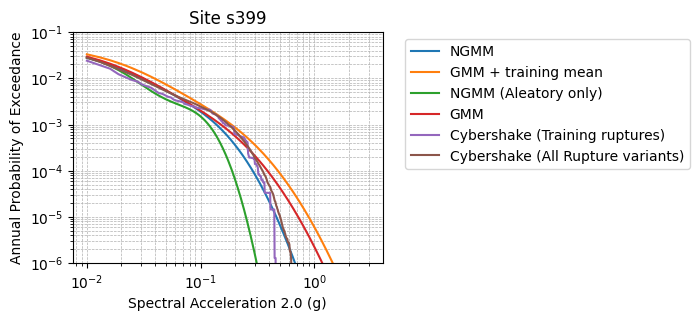

In [85]:
ln_sa_values = np.log(np.linspace(0.01, 3, 1000))
# num_epstemic_samples = 20
# ngmm_aleatory_poe_values = np.zeros((num_epstemic_samples, ln_sa_values.shape[0]))
ngmm_poe_values = np.zeros_like(ln_sa_values)
gmm_poe_values = np.zeros_like(ln_sa_values)
gmm_plus_ngmm_mean_poe_values = np.zeros_like(ln_sa_values)
ngmm_alea_only_poe_values = np.zeros_like(ln_sa_values)
cybershake_training_poe_values = np.zeros_like(ln_sa_values)
cybershake_all_rup_var_poe_values = np.zeros_like(ln_sa_values)
for i, row in ngmm_results_site.iterrows():
    gmm_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
        ln_sa_values, loc=np.log(row['gmm_mean']), 
        scale=row['gmm_ln_std'])
    )
    gmm_plus_ngmm_mean_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
        ln_sa_values, loc=np.log(row['gmm_mean']) + training_y_mean, 
        scale=row['gmm_ln_std'])
    )
    ngmm_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
        ln_sa_values, loc=np.log(row['gmm_mean'])+row['pred_mean'],
        scale=np.sqrt(row['pred_var'] + likelihood_noise))     
    )
    ngmm_alea_only_poe_values += row['probability'] * (1 - scipy.stats.norm.cdf(
        ln_sa_values, loc=np.log(row['gmm_mean'])+row['pred_mean'],
        scale=np.sqrt(likelihood_noise))
    )
    cybershake_training_poe_values += row['probability'] * (
        (np.log(row['gmm_mean']) + row['cybershake_res'] > ln_sa_values).astype(float)
    )
    rup_vars = cybershake_res[cybershake_res['eq_id'] == row['eq_id']]
    poe_rup_vars = np.array([(x > ln_sa_values).astype(float) for x in rup_vars['res'] + np.log(row['gmm_mean'])])
    poe_eq = poe_rup_vars.mean(axis=0)
    cybershake_all_rup_var_poe_values += row['probability'] * (
        poe_eq
    )
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.exp(ln_sa_values), ngmm_poe_values, label='NGMM')
ax.plot(np.exp(ln_sa_values), gmm_plus_ngmm_mean_poe_values, label='GMM + training mean')
ax.plot(np.exp(ln_sa_values), ngmm_alea_only_poe_values, label='NGMM (Aleatory only)')
ax.plot(np.exp(ln_sa_values), gmm_poe_values, label='GMM')
ax.plot(np.exp(ln_sa_values), cybershake_training_poe_values, label='Cybershake (Training ruptures)')
ax.plot(np.exp(ln_sa_values), cybershake_all_rup_var_poe_values, label='Cybershake (All Rupture variants)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax.set_xlabel('Spectral Acceleration 2.0 (g)')
ax.set_ylabel('Annual Probability of Exceedance')
ax.grid(True, which="both", ls="--", linewidth=0.5)
ax.set_title(f'Site {site_id}')
ax.set_ylim([1e-6, 1e-1])

Text(0, 0.5, 'NGMM Total ln_std')

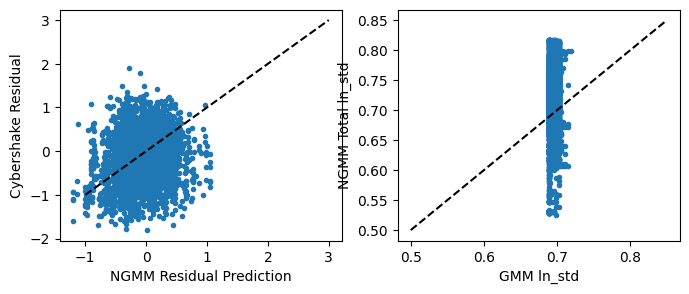

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(ngmm_results_site['pred_mean'], ngmm_results_site['cybershake_res'], '.')
ax[0].plot([-1, 3], [-1, 3], 'k--')
ax[0].set_xlabel('NGMM Residual Prediction')
ax[0].set_ylabel('Cybershake Residual')

ax[1].plot(ngmm_results_site['gmm_ln_std'], np.sqrt(ngmm_results_site['pred_var'] + likelihood_noise), '.')
ax[1].plot([0.5, 0.85], [0.5, 0.85], 'k--')
ax[1].set_xlabel('GMM ln_std')
ax[1].set_ylabel('NGMM Total ln_std')